We import `IBMQBackend` and load our IBM token from a .env file

In [2]:
from pytket.extensions.qiskit import IBMQBackend

from dotenv import load_dotenv
import os

In [3]:
load_dotenv()
ibm_token = os.getenv('IBM_QUANTUM_API_TOKEN')

for logging into the runtime service

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True)

Then we can check the QPUs (*Quantum Processing Units*) available to us and select one. In this case we'll select `ibm_brisbane`

In [5]:
backendinfo_list = IBMQBackend.available_devices()
print([backend.device_name for backend in backendinfo_list])

['ibm_brisbane', 'ibm_kyiv', 'ibm_sherbrooke']


In [7]:
backend = IBMQBackend("ibm_brisbane")

We then take a very small size puzzle

In [17]:
from python_package.Sudoku import Sudoku

sudoku = Sudoku(grid_size=2,num_missing_cells=3)

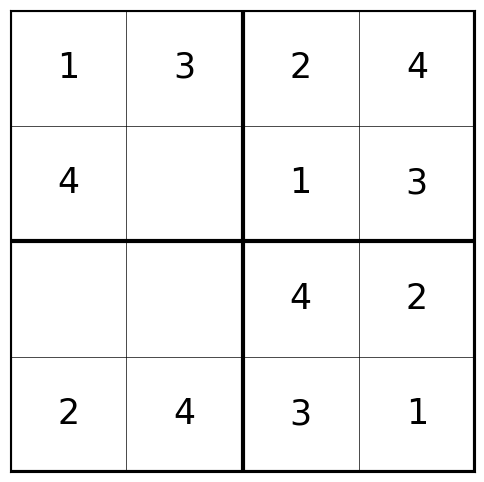

In [19]:
sudoku.plot()

We initialize the quantum solver object and find resources for the rough circuit:

In [18]:
sudoku._init_quantum(simple=False,pattern=True)

sudoku.quantum.find_resources()

# Number of qubits || Number of MCX gates || Total number of gates

(28, 186, 217)

Then we initialize and draw the circuit 

In [20]:
circuit = sudoku.quantum.get_circuit()

In [21]:
sudoku.quantum.draw_circuit()

We then compile for the selected backend.

(We use the `FlattenRegisters` function to fix the naming of our original circuit's registers and ensure compatibility with the backend's compiler)

In [22]:
from pytket.passes import FlattenRegisters

flatten = FlattenRegisters()
flatten.apply(circuit)

compiled_circuit = backend.get_compiled_circuit(circuit)

Notice that the resources are much higher than the uncompiled circuit's estimate. This is partially due to the architecture of the QPU, as we are building a highly entangled state but not every qubit can readily connect to every other qubit so intermediate gates and auxiliary qubits are required:

In [23]:
compiled_circuit.n_qubits

71

In [24]:
compiled_circuit.n_gates

137967

We process the circuit and plot the results:

In [26]:
handle = backend.process_circuit(compiled_circuit,n_shots = 1024)

(one can keep the `str(handle)` for later retrieval of the data)

In [27]:
# assert backend.persistent_handles
print(str(handle))
counts = backend.get_result(handle).get_counts()
print(counts)

('cw145sfvka8g008b9vp0', 0, 3, 'null')
Counter({(np.uint8(1), np.uint8(0), np.uint8(1)): 153, (np.uint8(1), np.uint8(1), np.uint8(0)): 143, (np.uint8(0), np.uint8(0), np.uint8(1)): 134, (np.uint8(0), np.uint8(0), np.uint8(0)): 131, (np.uint8(0), np.uint8(1), np.uint8(1)): 122, (np.uint8(0), np.uint8(1), np.uint8(0)): 119, (np.uint8(1), np.uint8(0), np.uint8(0)): 116, (np.uint8(1), np.uint8(1), np.uint8(1)): 106})


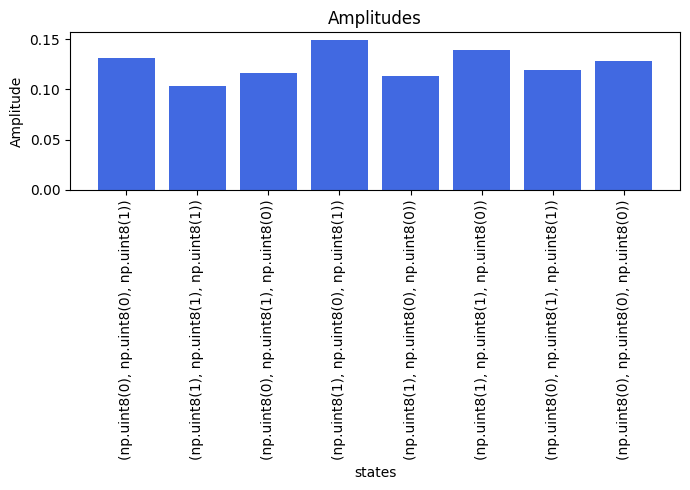

In [28]:
sudoku.quantum.counts_plot(counts)

In [ ]:
# Retrieve the data: from handle 
handle = ResultHandle.from_str("('5e8f3dcbbb7d8500119cfbf6', 0)")
counts = backend.get_result(handle).get_counts()

Notice that the results show a fairly uniform distribution of all possible results. This case corresponds to a failure due to the high resource requirements and the relatively low power of the QPU.

Let me elaborate:

From IBM's [website about their QPUs](https://quantum.ibm.com/services/resources) we can find `ibm_brisbane`'s details, in particular, its coherence times and circuit layer operations per second (CLOPS):

*Median T1 (Relaxation Time)*: $220.84 μs = 0.00022084 s$

- This is the average time a qubit remains in an excited state before decaying to its ground state.

*Median T2 (Dephasing Time)*: $134.91 μs = 0.00013491 s$

- This is the average time over which a qubit can maintain its coherence, or superposition, before losing its phase information due to environmental noise and interactions.

*CLOPS*: $30,000$

- This means the processor can execute 30,000 circuit layers per second.

In our example, if we assume the maximum of $1,943$ gates per layer -based on a maximum of $71$ gates per layer from a total of $137,967$ gates-at a rate of $30,000$ CLOPS results in a total execution time of

$$
\frac{\text{Circuit Depth}}{\text{CLOPS}} = \frac{1,943}{30,000 \text{layers}/\text{s}} \approx 0.065 \text{s}
$$

Which is a couple orders of magnitude greater than the coherence times. So even in the best case, our quantum state would no longer maintain coherence way before the algorithm finished.